In [15]:
import sys
import os

def get_dir_n_levels_up(path, n):
    # Go up n levels from the given path
    for _ in range(n):
        path = os.path.dirname(path)
    return path

proj_root = get_dir_n_levels_up(os.path.abspath("__file__"), 4)
sys.path.append(proj_root)

import yaml
import torch
import numpy as np

from dqn.opinion_dynamics.opinion_dqn import AgentDQN
from dqn.opinion_dynamics.utils.my_logging import setup_logger
from dqn.opinion_dynamics.utils.experiment import build_environment

from dynamic_programming.opinion_dynamics.common.viz import plot_opinions_over_time, visualize_policy_from_env


def instantiate_agent(exp_subdir_path: str) -> AgentDQN:
    """
    Instantiate an AgentDQN using the configuration stored in a YAML file 
    in the provided experiment subdirectory. The agent is created with the 
    given training and validation environments and loads its previous state.
    
    Args:
        exp_subdir_path (str): Path to the experiment subdirectory containing the config YAML and checkpoint files.

    
    Returns:
        AgentDQN: An instance of AgentDQN initialized using the experiment configuration and saved state.
    """
    # Assume the YAML configuration is stored as 'config.yaml' in the experiment folder.
    config_path = os.path.join(exp_subdir_path, "cfg.yaml")
    if not os.path.exists(config_path):
        raise FileNotFoundError(f"Config file not found at {config_path}")
    
    with open(config_path, "r") as f:
        config = yaml.safe_load(f)
    
    # Instantiate the agent.
    # The resume_training_path is set to the experiment folder so that the agent loads saved weights/stats.
    agent = AgentDQN(
        resume_training_path=exp_subdir_path,
        experiment_name=config["experiment"],
        config=config,
        save_checkpoints=False,  # you can set this as needed
        logger=setup_logger("dqn")
    )
    
    return agent

def run_policy_agent(agent, max_steps=1000):
    """
    Run the simulation using the agent’s policy (exploitation only).
    
    Args:
        env: The environment (which must have a reset and step method).
        agent: An already-trained AgentDQN instance.
        max_steps: Maximum number of steps to run.
        
    Returns:
        opinions_over_time: Array of opinions (states) over time.
        time_points: Array of time stamps.
        rewards_over_time: Array of rewards collected at each step.
        actions_over_time: Array of actions taken at each step.
    """
    time_points = []
    rewards_over_time = []
    actions_over_time = []  # New: record the actions used.
    opinions_over_time = []
    env = agent.validation_env
    
    current_time = 0.0
    # Reset environment
    state, _ = env.reset()
    opinions_over_time.append(state.copy())
    
    for step in range(max_steps):
        # Convert state to a batched tensor (batch size = 1)
        state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
        # Use the agent in exploitation mode (epsilon=0, random_action=False)
        # The agent.select_action returns (action, beta_idx, q_value)
        action, _, _, _ = agent.select_action(state_tensor, epsilon=0.0, random_action=False)
        # action is returned as a NumPy array with shape (1, n_agents)
        action = np.squeeze(action)  # Now action has shape (n_agents,)
        actions_over_time.append(action.copy())
        
        # Apply the action in the environment.
        next_state, reward, done, truncated, _ = env.step(action, env.tau)
        opinions_over_time.append(next_state.copy())
        rewards_over_time.append(reward)
        time_points.append(current_time)
        
        current_time += env.tau
        state = next_state
        
        if done or truncated:
            print(f"Simulation ended at step {step}: done={done}, truncated={truncated}")
            break

    return (np.array(opinions_over_time),
            np.array(time_points),
            np.array(rewards_over_time),
            np.array(actions_over_time))

2025-04-29 01:16:13,582 - dqn - INFO - opinion_dqn.py:218 - Loaded configuration settings.
2025-04-29 01:16:13,591 - dqn - INFO - opinion_dqn.py:277 - Initialized newtworks and optimizer.
2025-04-29 01:16:19,304 - dqn - INFO - opinion_dqn.py:163 - Loaded previous training status from the following files: {'replay_buffer_file': 'D:\\Work\\repos\\RL\\phd-rl-algos\\dqn\\opinion_dynamics\\experiments\\results\\2025Apr28-221058_configs\\0000_agent_params.args_.action_w_noise_amplitude_0\\1\\opinion_agent_dqn_replay_buffer', 'train_stats_file': 'D:\\Work\\repos\\RL\\phd-rl-algos\\dqn\\opinion_dynamics\\experiments\\results\\2025Apr28-221058_configs\\0000_agent_params.args_.action_w_noise_amplitude_0\\1\\opinion_agent_dqn_train_stats', 'checkpoint_model_file': 'D:\\Work\\repos\\RL\\phd-rl-algos\\dqn\\opinion_dynamics\\experiments\\results\\2025Apr28-221058_configs\\0000_agent_params.args_.action_w_noise_amplitude_0\\1\\model_checkpoints\\mck_20'}
Simulation ended at step 16: done=True, trunca

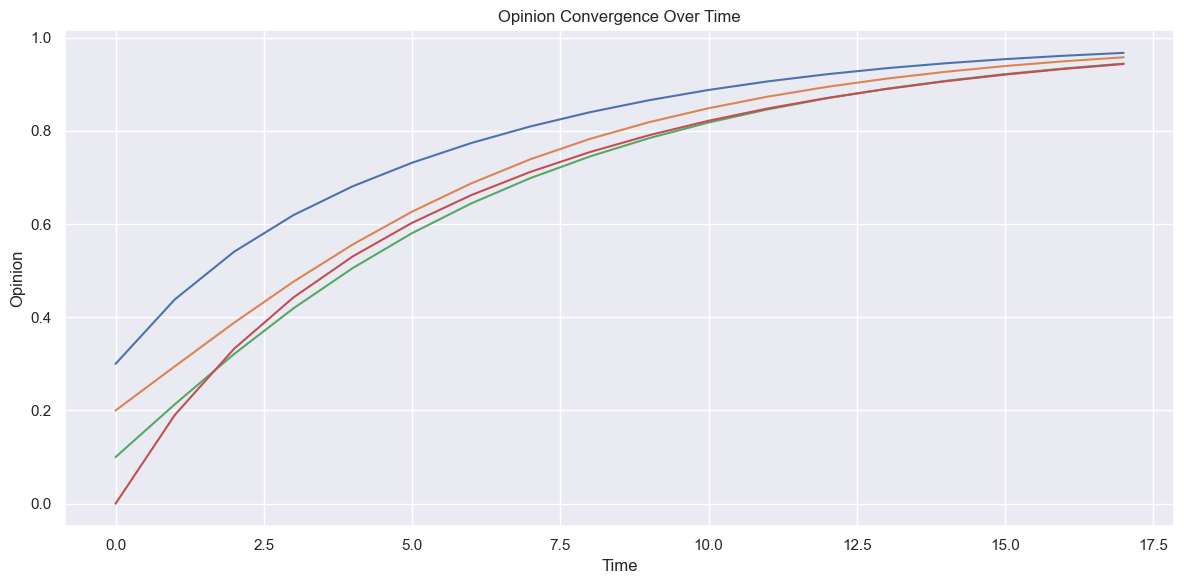

In [16]:
# best performing
# exp_subdir = r"D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dynamics\experiments\results\2025Apr22-104437_configs\0003_agent_params.args_.action_w_noise_amplitude_0.6\0"

# last run
exp_subdir = r"D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dynamics\experiments\results\2025Apr28-221058_configs\0000_agent_params.args_.action_w_noise_amplitude_0\1"

agent = instantiate_agent(exp_subdir)

max_steps = 30
states, times, rewards, actions = run_policy_agent(agent, max_steps=max_steps)

plot_opinions_over_time(states)


In [17]:
len(actions)

17

In [18]:
actions

array([[0.2337455 , 0.09802283, 0.08937897, 0.17885272],
       [0.22636586, 0.10824231, 0.09275181, 0.17264001],
       [0.22017576, 0.11738145, 0.09545971, 0.16698314],
       [0.21493624, 0.12545848, 0.09776971, 0.16183558],
       [0.21195273, 0.13199297, 0.09907953, 0.15697484],
       [0.21265288, 0.13647953, 0.09874664, 0.15212099],
       [0.21386774, 0.14034484, 0.09833942, 0.14744803],
       [0.21615577, 0.14151306, 0.0982281 , 0.1441031 ],
       [0.21923433, 0.14064418, 0.09830841, 0.14181313],
       [0.2226411 , 0.1394302 , 0.09829689, 0.13963185],
       [0.2249151 , 0.13979861, 0.09767534, 0.13761099],
       [0.2264537 , 0.14101638, 0.09688336, 0.1356466 ],
       [0.22807294, 0.14200829, 0.09625936, 0.1336594 ],
       [0.22817126, 0.1431483 , 0.09543861, 0.13324186],
       [0.22736105, 0.14439176, 0.09439199, 0.13385521],
       [0.22657329, 0.14558266, 0.09325857, 0.1345855 ],
       [0.22578566, 0.14675507, 0.09200165, 0.13545768]], dtype=float32)

In [19]:
gamma = 0.9
total_value = 0
for i, r in enumerate(rewards):
    total_value = total_value + (gamma**i) * r
    
total_value

-16.005271181172173

In [20]:
sum(rewards)

-24.647195442145218